In [1]:
import torch
import numpy as np
import matplotlib. pyplot as plt
import torch.nn as nn
import math 

from sklearn.model_selection import KFold

**Problem 1**

In [2]:
# y = 2x +ε
torch.manual_seed(35)
num_points = 15
x = torch.linspace(-3, 3, 15)
origin_x = x
epsilon = torch.randn(15)
y = 2 * x + epsilon
# y = y.unsqueeze(1)
origin_y = y
print(x)
print(y)

tensor([-3.0000e+00, -2.5714e+00, -2.1429e+00, -1.7143e+00, -1.2857e+00,
        -8.5714e-01, -4.2857e-01, -2.9802e-08,  4.2857e-01,  8.5714e-01,
         1.2857e+00,  1.7143e+00,  2.1429e+00,  2.5714e+00,  3.0000e+00])
tensor([-5.0326, -4.4717, -3.7689, -3.1209, -2.6625, -1.9770,  1.0074, -0.6919,
         1.8821,  2.3990,  1.7763,  1.8114,  6.4094,  5.1596,  6.7926])


**Problem 2**

Degrees = 1

In [3]:
def generate_polynomial_regression_matrix(degrees, data): # degrees > 1
  degrees_X = []
  for element in data:
    temp_list = []
    for i in range(degrees , -1, -1):
      temp_list.append(element.item() ** i)
    degrees_X.append(temp_list)  

  degrees_X = torch.tensor(degrees_X)

  return degrees_X

In [4]:
def generate_predicted_y(degrees, origin_y, degrees_X):
  X_pseudo_inverse = torch.linalg.pinv(degrees_X)
  WLin = torch.matmul(X_pseudo_inverse, origin_y) 
  predicted_y = torch.matmul(WLin, torch.t(degrees_X))
  return predicted_y, WLin

In [5]:
# Plots training data, test data and compares predictions.

def plot_predictions(origin_data, origin_labels, predicted_value, degrees, predictions):
  
  plt.figure(figsize=(5, 3))
  plt.title("Degrees: " + str(degrees))
  # Plot training data in blue
  plt.scatter(origin_data, origin_labels, c="b", s=4, label="Origin data")
 
  
  plt.plot(origin_data, predicted_value, c="orange", label="Prediction")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 10});

In [6]:
def k_fold_cross_validation_with_regularization(K, origin_x, origin_y, degrees, lamba, regularization):
    
    kfold = KFold(n_splits=K)

    validation_error_list = []
    origin_x_y_pair = torch.cat((origin_x.unsqueeze(1), origin_y.unsqueeze(1)), 1)


    for fold_i, (train_ids, val_ids) in enumerate(kfold.split(origin_x_y_pair)):
        # print(fold_i, (train_ids, val_ids))
        
        train_indices = train_ids.tolist()
        validation_indices = val_ids.tolist()

        if degrees > 1:
          x_train = torch.index_select(origin_x, 0, torch.tensor(train_indices))
          y_train = torch.index_select(origin_y, 0, torch.tensor(train_indices))
          x_validation = torch.index_select(origin_x, 0, torch.tensor(validation_indices))
          y_validation = torch.index_select(origin_y, 0, torch.tensor(validation_indices))

          origin_x_train = x_train
          origin_y_train = y_train
          origin_x_validation = x_validation
          origin_y_validation = y_validation

          x_train = generate_polynomial_regression_matrix(degrees, x_train)
          x_validation = generate_polynomial_regression_matrix(degrees, x_validation)

        else :
          x_train = torch.cat((torch.index_select(origin_x, 0 , torch.tensor(train_indices)).unsqueeze(1), torch.ones(len(train_indices)).unsqueeze(1)), 1)
          y_train = torch.index_select(origin_y, 0, torch.tensor(train_indices))

          x_validation = torch.cat((torch.index_select(origin_x, 0, torch.tensor(validation_indices)).unsqueeze(1), torch.ones(len(validation_indices)).unsqueeze(1)), 1)
          y_validation = torch.index_select(origin_y, 0, torch.tensor(validation_indices))

        if regularization:
          # Training 
          Wreg = compute_Wreg(x_train, lamba, y_train)
          predicted_y_train = torch.matmul(torch.t(Wreg), torch.t(x_train))
          # predicted_y_train = torch.matmul(torch.t(WLin_x_train), torch.t(x_train))
          loss = nn.MSELoss()
          training_error = loss(y_train, predicted_y_train)

          # Validation
          
          predicted_y_validation = torch.matmul(torch.t(Wreg), torch.t(x_validation))
          loss = nn.MSELoss()
          validation_error = loss(y_validation, predicted_y_validation)
          validation_error_list.append(validation_error)
        else :
          # Training 
          x_train_pseudo_inverse = torch.linalg.pinv(x_train)
          WLin_x_train = torch.matmul(x_train_pseudo_inverse, y_train) 
          # predicted_y_train = torch.matmul(torch.t(WLin_x_train), torch.t(x_train))
          predicted_y_train = torch.matmul(WLin_x_train, torch.t(x_train))
          loss = nn.MSELoss()
          training_error = loss(y_train, predicted_y_train)

          # Validation
        
          predicted_y_validation = torch.matmul(WLin_x_train, torch.t(x_validation))
          loss = nn.MSELoss()
          validation_error = loss(y_validation, predicted_y_validation)
          validation_error_list.append(validation_error)
       
    k_fold_error = sum(validation_error_list) / len(validation_error_list)    
    print(str(K) + "-Fold Cross-Validation Error: " + str(k_fold_error.item()) + " (mean squared error)")
      

Training Error is:  0.9024458527565002 (mean squared error)
5-Fold Cross-Validation Error: 1.6708343029022217 (mean squared error)


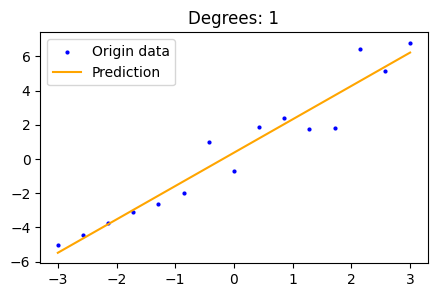

In [7]:
degrees = 1 
degrees_X = generate_polynomial_regression_matrix(degrees, origin_x)
predicted_y, W = generate_predicted_y(degrees, origin_y, degrees_X)
plot_predictions(origin_x, origin_y, predicted_y, degrees, None)

loss = nn.MSELoss()
training_error = loss(origin_y, predicted_y)
print("Training Error is: ", training_error.item(), "(mean squared error)")
k_fold_cross_validation_with_regularization(5, origin_x, origin_y, degrees, 0,False)

**Problem 3**

Degrees = 5

Training Error is:  0.8215705156326294 (mean squared error)
5-Fold Cross-Validation Error: 81.16810607910156 (mean squared error)


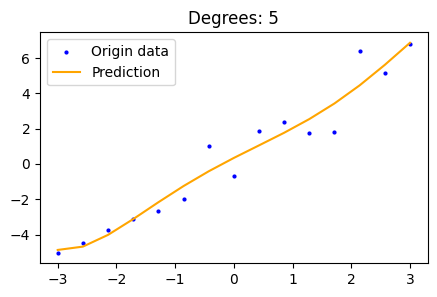

In [8]:
degrees_X = generate_polynomial_regression_matrix(5, origin_x)
# Degrees = 5
predicted_y, W = generate_predicted_y(5, origin_y, degrees_X)
plot_predictions(origin_x, origin_y, predicted_y, 5, None)

loss = nn.MSELoss()
training_error = loss(origin_y, predicted_y)
print("Training Error is: ", training_error.item(), "(mean squared error)")
k_fold_cross_validation_with_regularization(5, origin_x, origin_y, 5, 0, False)

Degrees = 10

Training Error is:  0.3539617955684662 (mean squared error)
5-Fold Cross-Validation Error: 990975.875 (mean squared error)


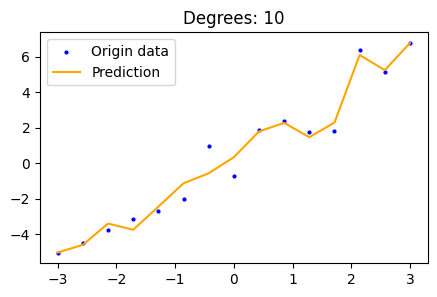

In [9]:
degrees_X = generate_polynomial_regression_matrix(10, origin_x)
predicted_y, W = generate_predicted_y(10, origin_y, degrees_X)
plot_predictions(origin_x, origin_y, predicted_y, 10, None)

loss = nn.MSELoss()
training_error = loss(origin_y, predicted_y)
print("Training Error is: ", training_error.item(), "(mean squared error)")
k_fold_cross_validation_with_regularization(5, origin_x, origin_y, 10, 0,False)

Degrees = 14

Training Error is:  1.60736882686615 (mean squared error)
5-Fold Cross-Validation Error: 205014208.0 (mean squared error)


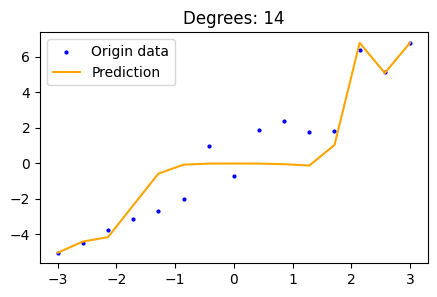

In [10]:
degrees_X = generate_polynomial_regression_matrix(14, origin_x)
predicted_y, W = generate_predicted_y(14, origin_y, degrees_X)
plot_predictions(origin_x, origin_y, predicted_y, 14, None)

loss = nn.MSELoss()
training_error = loss(origin_y, predicted_y)
print("Training Error is: ", training_error.item(), "(mean squared error)")
k_fold_cross_validation_with_regularization(5, origin_x, origin_y, 14, 0, False)

**Problem 4**

In [11]:
num_points = 15
def generate_sin_data(num_points): # return x, y data
  x = torch.linspace(0, 1, num_points)
  epsilon = torch.randn(num_points) * 0.2 # since variance is 0.04, standard deviation is sqrt(0.04) = 0.2
  y = torch.sin(2 * math.pi * x) + epsilon

  return x, y

In [12]:
origin_x, origin_y = generate_sin_data(num_points)

Degree = 1

Training Error is:  0.30867519974708557 (mean squared error)
5-Fold Cross-Validation Error: 0.762559711933136 (mean squared error)


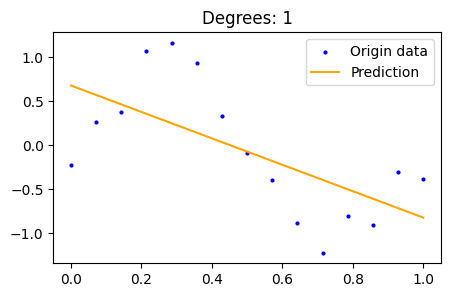

In [13]:
degrees = 1
degrees_X = generate_polynomial_regression_matrix(degrees, origin_x)
predicted_y, W = generate_predicted_y(degrees, origin_y, degrees_X)
plot_predictions(origin_x, origin_y, predicted_y, degrees, None)

loss = nn.MSELoss()
training_error = loss(origin_y, predicted_y)
print("Training Error is: ", training_error.item(), "(mean squared error)")
k_fold_cross_validation_with_regularization(5, origin_x, origin_y, degrees, 0, False)

Degree = 5

Training Error is:  0.01661587320268154 (mean squared error)
5-Fold Cross-Validation Error: 0.6186081171035767 (mean squared error)


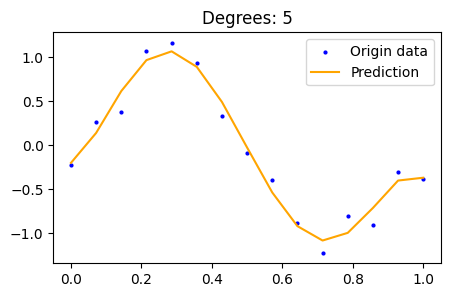

In [14]:
degrees = 5
degrees_X = generate_polynomial_regression_matrix(degrees, origin_x)
predicted_y, W = generate_predicted_y(degrees, origin_y, degrees_X)
plot_predictions(origin_x, origin_y, predicted_y, degrees, None)

loss = nn.MSELoss()
training_error = loss(origin_y, predicted_y)
print("Training Error is: ", training_error.item(), "(mean squared error)")
k_fold_cross_validation_with_regularization(5, origin_x, origin_y, degrees, 0, False)

Degree = 10

Training Error is:  0.014223647303879261 (mean squared error)
5-Fold Cross-Validation Error: 3332.671875 (mean squared error)


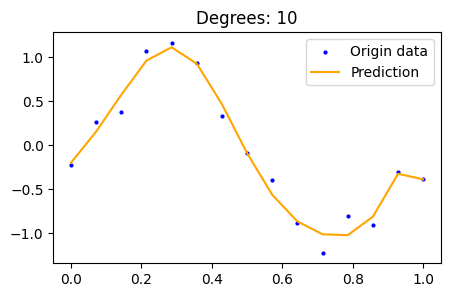

In [15]:
degrees = 10
degrees_X = generate_polynomial_regression_matrix(degrees, origin_x)
predicted_y, W = generate_predicted_y(degrees, origin_y, degrees_X)
plot_predictions(origin_x, origin_y, predicted_y, degrees, None)

loss = nn.MSELoss()
training_error = loss(origin_y, predicted_y)
print("Training Error is: ", training_error.item(), "(mean squared error)")
k_fold_cross_validation_with_regularization(5, origin_x, origin_y, degrees, 0, False)

Degree = 14

Training Error is:  0.014435188844799995 (mean squared error)
5-Fold Cross-Validation Error: 56095.4609375 (mean squared error)


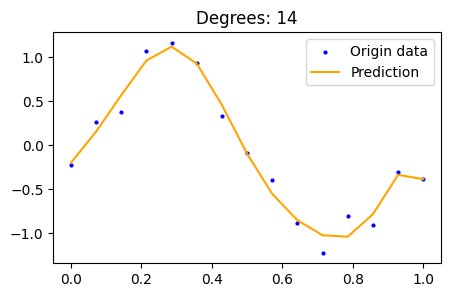

In [16]:
degrees = 14
degrees_X = generate_polynomial_regression_matrix(degrees, origin_x)
predicted_y, W = generate_predicted_y(degrees, origin_y, degrees_X)
plot_predictions(origin_x, origin_y, predicted_y, degrees, None)

loss = nn.MSELoss()
training_error = loss(origin_y, predicted_y)
print("Training Error is: ", training_error.item(), "(mean squared error)")
k_fold_cross_validation_with_regularization(5, origin_x, origin_y, degrees, 0, False)

**Problem 5**

Training Error is:  0.0014178322162479162 (mean squared error)
5-Fold Cross-Validation Error: 48931.18359375 (mean squared error)
Training Error is:  0.03948710486292839 (mean squared error)
5-Fold Cross-Validation Error: 22.365032196044922 (mean squared error)
Training Error is:  0.03321254998445511 (mean squared error)
5-Fold Cross-Validation Error: 0.9071736335754395 (mean squared error)


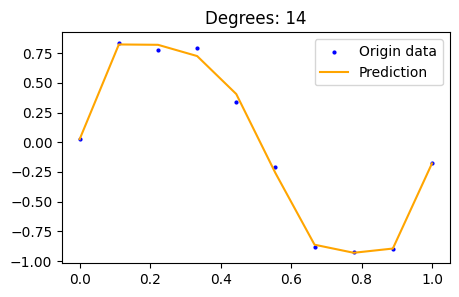

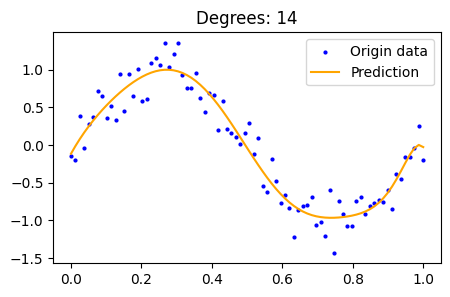

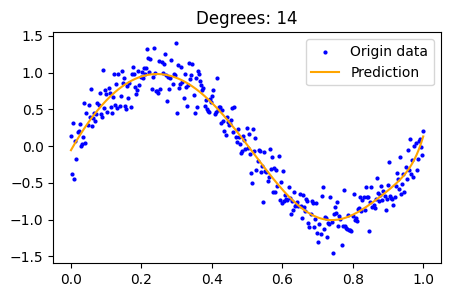

In [17]:
num_points_list = [10, 80, 320]
degrees = 14
for num_points in num_points_list:
  # num_points = 1080320 
  # origin_x = torch.linspace(0, 1, num_points)
  origin_x, origin_y = generate_sin_data(num_points) # shape = 1080320 x 15
  degrees_X = generate_polynomial_regression_matrix(degrees, origin_x)
  
  predicted_y, W = generate_predicted_y(degrees, origin_y, degrees_X)
  plot_predictions(origin_x, origin_y, predicted_y, degrees, None)
  loss = nn.MSELoss()
  training_error = loss(origin_y, predicted_y)
  print("Training Error is: ", training_error.item(), "(mean squared error)")
  k_fold_cross_validation_with_regularization(5, origin_x, origin_y, degrees, 0, False)
  

**Problem 6**

In [18]:
def compute_Wreg(Z, lamba, y):
  Z_transpose = torch.t(Z)
  y = y.unsqueeze(1)
  Wreg = torch.matmul(torch.matmul(torch.inverse(torch.add(torch.matmul(Z_transpose, Z), lamba * torch.eye(Z.shape[1]))), Z_transpose), y)

  return Wreg

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targ

Training Error is:  1.1391408443450928 (mean squared error)
5-Fold Cross-Validation Error: 16787844.0 (mean squared error)
Training Error is:  0.9118373394012451 (mean squared error)
5-Fold Cross-Validation Error: 38.916656494140625 (mean squared error)
Training Error is:  0.7397658824920654 (mean squared error)
5-Fold Cross-Validation Error: 0.9209146499633789 (mean squared error)
Training Error is:  0.47869107127189636 (mean squared error)
5-Fold Cross-Validation Error: 0.5066391229629517 (mean squared error)


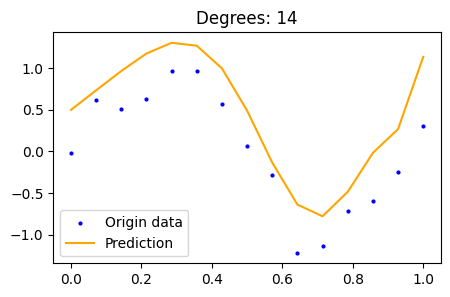

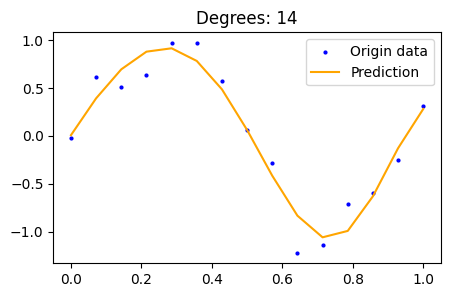

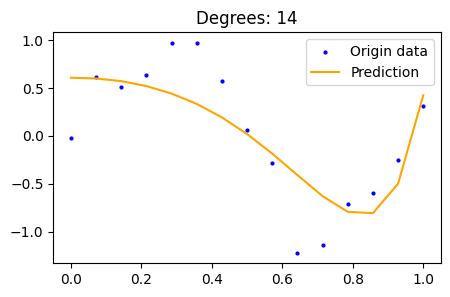

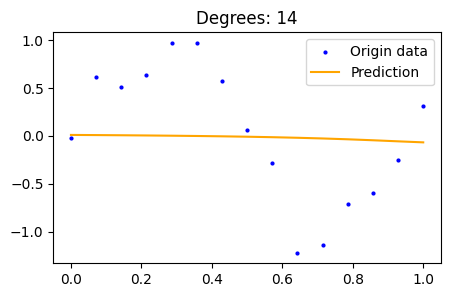

In [19]:
num_points = 15
degrees = 14
# λ = 0, 0.001/m , 1/m, 1000/m
lambas = [0, 0.001 / num_points, 1 / num_points, 1000 / num_points]
origin_x, origin_y = generate_sin_data(num_points)
degrees_X = generate_polynomial_regression_matrix(degrees, origin_x)
for lamba in lambas:
  Wreg = compute_Wreg(degrees_X, lamba, origin_y)
  predicted_y = torch.matmul(degrees_X, Wreg)
  plot_predictions(origin_x, origin_y, predicted_y, degrees, None)
  # k_fold_cross_validation(5, origin_x, origin_y, degrees, )
  loss = nn.MSELoss()
  training_error = loss(origin_y, predicted_y)
  print("Training Error is: ", training_error.item(), "(mean squared error)")
  k_fold_cross_validation_with_regularization(5, origin_x, origin_y, degrees, lamba, True)
  